In [1]:
exp = "exp050_llama"
device_id = 0

In [2]:
import glob
import os
import sys
from base64 import b64decode
from io import BytesIO
from PIL import Image

from transformers import (
    AutoTokenizer,
    CLIPImageProcessor,
    AutoProcessor,
    TrainingArguments,
    Trainer,
    AutoModelForCausalLM
)
import datasets
import torch
from torch.utils.data import Dataset
import yaml
import deepspeed
import fire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from peft import LoraConfig, get_peft_config, get_peft_model


from git_llm.git_opt import GitOPTForCausalLM, GitOPTConfig
from git_llm.git_llama import GitLlamaForCausalLM, GitLlamaConfig

[2023-08-09 03:11:29,783] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
sys.path.append('..')
from train import load_model, apply_lora_model

# Functions

In [4]:
def generate_text(model, data):
    eos_token_id_list = [
        supervised_test_dataset.processor.tokenizer.pad_token_id,
        supervised_test_dataset.processor.tokenizer.eos_token_id,
    ]
    with torch.no_grad():
        out = model.generate(**data, max_length=256, do_sample=False, temperature=0., eos_token_id=eos_token_id_list)
        return supervised_test_dataset.processor.tokenizer.batch_decode(out)

# SupervisedDataset
class SupervisedDataset(Dataset):
    """Dataset for supervised learning"""

    def __init__(
        self,
        model_name: str,
        vision_model_name: str,
        loaded_dataset: datasets.GeneratorBasedBuilder,
        max_length: int = 128,
    ):
        super(SupervisedDataset, self).__init__()
        self.loaded_dataset = loaded_dataset
        self.max_length = max_length

        self.processor = AutoProcessor.from_pretrained("microsoft/git-base")
        self.processor.image_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
        self.processor.tokenizer = AutoTokenizer.from_pretrained(
            model_name, padding_side="right", use_fast=False
        )
        if "llama" in model_name:
            self.processor.tokenizer.pad_token = self.processor.tokenizer.eos_token

    def __len__(self) -> int:
        return len(self.loaded_dataset)

    def __getitem__(self, index) -> dict:
        # cf: https://huggingface.co/datasets/MMInstruction/M3IT#data-instances
        row = self.loaded_dataset[index]

        instruction = row["instruction"]  # str
        question = row["inputs"]  # str
        answer = row["outputs"]  # str
        full_text = f"##Instruction: {instruction} ##Question: {question} ##Answer: {answer}"
        text = f"##Instruction: {instruction} ##Question: {question} ##Answer:"

        # imageのロード
        image_base64_str_list = row["image_base64_str"]  # str (base64)
        img = Image.open(BytesIO(b64decode(image_base64_str_list[0])))

        inputs = self.process_data(text, img)

        return inputs, img, text, full_text

    def process_data(self, text, img):
        inputs = self.processor(
            text,
            img,
            return_tensors="pt",
            # max_length=self.max_length,
            # padding="max_length",
            truncation=True,
        )
        inputs = {k: v.to(f"cuda:{device_id}") for k, v in inputs.items()}
        inputs["pixel_values"] = inputs["pixel_values"].to(torch.float16)
        inputs["labels"] = None
        return inputs

# Load configs

In [5]:
config_file = f"../configs/training_config_{exp}.yml"

# get config
with open(config_file, "r") as i_:
    config = yaml.safe_load(i_)


# model
model_name = config["settings"]["model_name"]
vision_model_name = config["settings"]["vision_model_name"]
num_image_with_embedding = config["settings"]["num_image_with_embedding"]

keys_finetune = config["settings"]["keys_finetune"]

# Load a pretrained model

In [6]:
model = load_model(model_name, vision_model_name, num_image_with_embedding)

# lora
if config["use_lora"]:
    keys_finetune.append("lora")
    model = apply_lora_model(model, model_name, config)

weight = {}
weight_path = glob.glob(f'../output/{exp}/checkpoint*/pytorch*.bin')
for w in weight_path:
    weight_temp = torch.load(w, map_location="cpu")
    weight.update(weight_temp)
model.load_state_dict(weight, strict=False)

model.eval()
model.to(f"cuda:{device_id}")
print("Complete preparing an eval model")

You are using a model of type llama to instantiate a model of type git_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GitLlamaForCausalLM were not initialized from the model checkpoint at meta-llama/Llama-2-7b-chat-hf and are newly initialized: ['model.image_encoder.vision_model.encoder.layers.9.mlp.fc2.weight', 'model.image_encoder.vision_model.encoder.layers.1.mlp.fc2.bias', 'model.image_encoder.vision_model.encoder.layers.4.self_attn.q_proj.bias', 'model.image_encoder.vision_model.encoder.layers.4.self_attn.out_proj.bias', 'model.image_encoder.vision_model.encoder.layers.4.layer_norm2.bias', 'model.image_encoder.vision_model.encoder.layers.3.layer_norm1.weight', 'model.image_encoder.vision_model.encoder.layers.2.layer_norm1.weight', 'model.image_encoder.vision_model.encoder.layers.9.layer_norm1.weight', 'model.image_encoder.vision_model.encoder.layers.6.self_attn.v_proj.weight', 'model.image_encoder.vision_model.encoder.layers.2.self_attn.out_proj.bias', 'model.image_encoder.vision_model.encoder.layers.3.mlp.fc2.bias', 'model.image_encoder.vision_model.encoder.layers.9.self_attn.out

Complete preparing an eval model


# Inference

Found cached dataset m3_it (/home/y_inoue/.cache/huggingface/datasets/MMInstruction___m3_it/coco/1.0.0/631dfd20153e0fbacb50b0239d4a71727503813fa0e821ba5ab399bed706034e)


  0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--------------------
['<s> ##Instruction: Write a succinct description of the image, capturing its main components, the relationships between them, and any notable details. ##Question:  ##Answer: A street sign with a street name and a parking sign.</s>']
##Instruction: Write a succinct description of the image, capturing its main components, the relationships between them, and any notable details. ##Question:  ##Answer: A large wooden pole with a green street sign hanging from it.


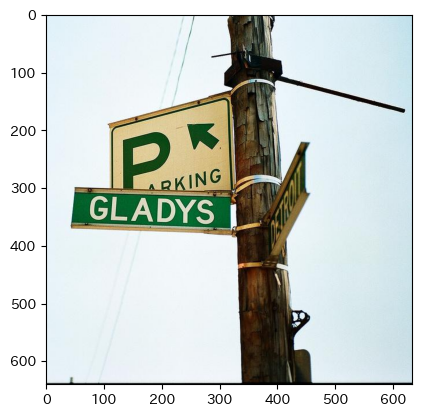

--------------------
['<s> ##Instruction: Generate a short caption for the picture. ##Question:  ##Answer: A man and a woman standing next to each other.</s>']
##Instruction: Generate a short caption for the picture. ##Question:  ##Answer: A man with a snowboard next to a man with a mask.


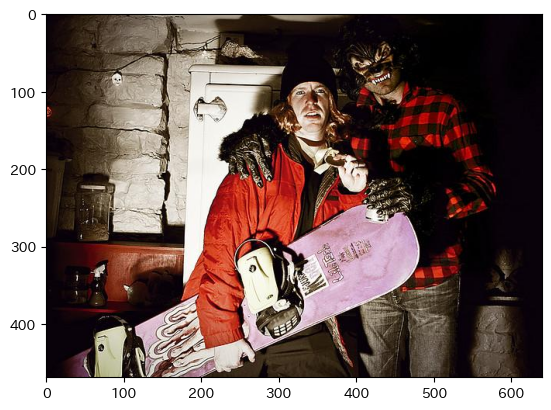

--------------------
['<s> ##Instruction: Write a clear description of the image, make sure the key features are well covered. ##Question:  ##Answer: A cow standing in the middle of a street.</s>']
##Instruction: Write a clear description of the image, make sure the key features are well covered. ##Question:  ##Answer: A cow standing near a curb in front of a store.


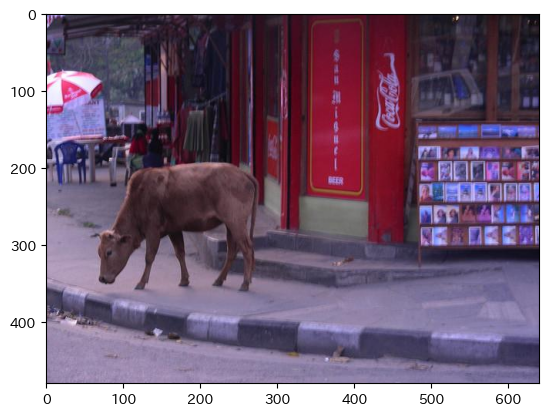

--------------------
["<s> ##Instruction: Offer a succinct explanation of the picture presented. ##Question:  ##Answer: A cat is eating a banana from a person's hand.</s>"]
##Instruction: Offer a succinct explanation of the picture presented. ##Question:  ##Answer: a cat that is eating some kind of banana


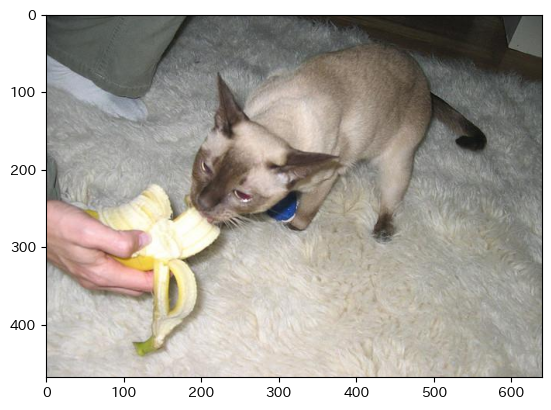

--------------------
['<s> ##Instruction: Describe the image briefly. ##Question:  ##Answer: A cow standing in a field next to a tree.</s>']
##Instruction: Describe the image briefly. ##Question:  ##Answer: two cows outside one laying down and the other standing near a building


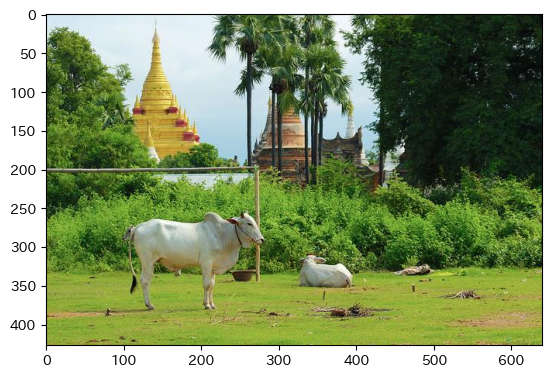

--------------------
['<s> ##Instruction: Provide a concise and informative caption for the image, focusing on the primary subjects. ##Question:  ##Answer: A woman with a black and white face paint.</s>']
##Instruction: Provide a concise and informative caption for the image, focusing on the primary subjects. ##Question:  ##Answer: An image of a very cute girl with face piercings.


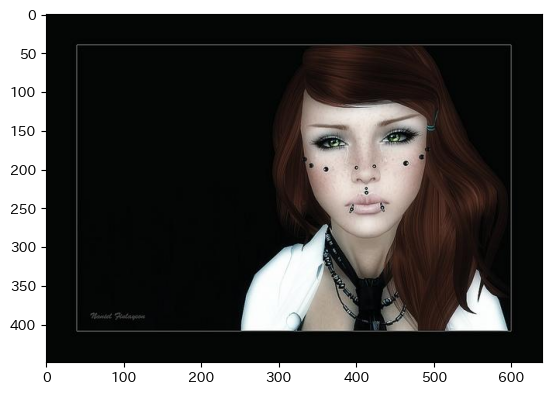

--------------------
['<s> ##Instruction: For the given image, provide a one-sentence summary that captures the most important details. ##Question:  ##Answer: A large elephant standing in a field next to a tree.</s>']
##Instruction: For the given image, provide a one-sentence summary that captures the most important details. ##Question:  ##Answer: An elephant standing under the shade of a tree.


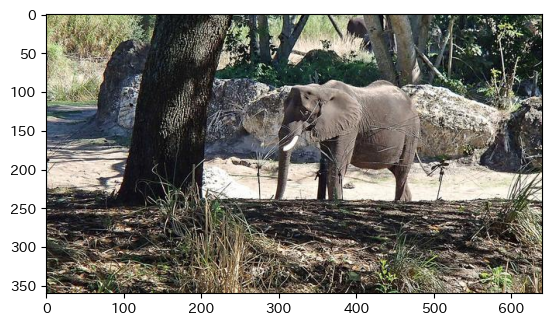

--------------------
['<s> ##Instruction: Provide a concise and informative caption for the image, focusing on the primary subjects. ##Question:  ##Answer: A group of boats docked at a marina.</s>']
##Instruction: Provide a concise and informative caption for the image, focusing on the primary subjects. ##Question:  ##Answer: A blue boat docked on a green lush shore.


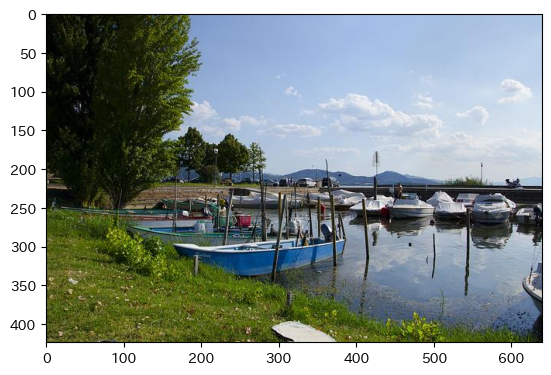

--------------------
['<s> ##Instruction: Write a short and informative description that highlights the primary subjects and actions occurring in the given image. ##Question:  ##Answer: A woman and a child are sitting on a bench.</s>']
##Instruction: Write a short and informative description that highlights the primary subjects and actions occurring in the given image. ##Question:  ##Answer: A woman embracing a child carrying a bag of luggage.


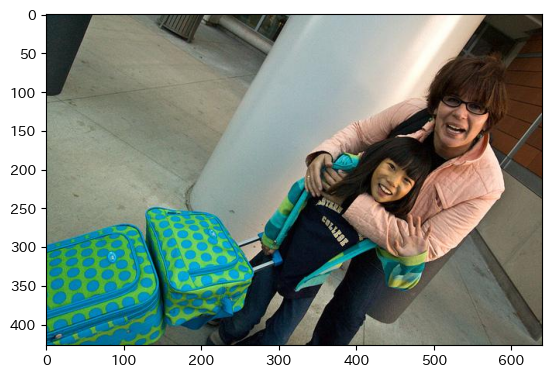

--------------------
['<s> ##Instruction: Create a concise caption that accurately describes the main elements in the image provided. ##Question:  ##Answer: A woman sitting on a suitcase in the woods.</s>']
##Instruction: Create a concise caption that accurately describes the main elements in the image provided. ##Question:  ##Answer: A woman sitting on a piece of luggage in a field.


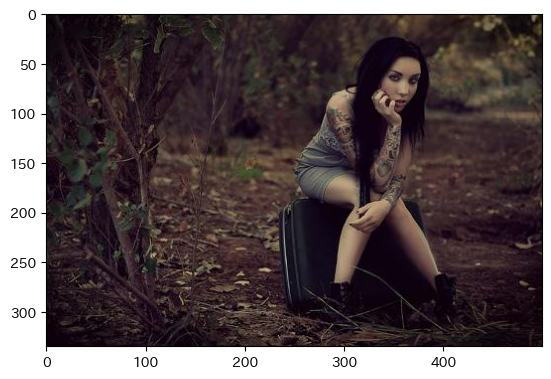

--------------------
['<s> ##Instruction: Provide a concise and informative caption for the image, focusing on the primary subjects. ##Question:  ##Answer: A dog is sitting in the sun in a backyard.</s>']
##Instruction: Provide a concise and informative caption for the image, focusing on the primary subjects. ##Question:  ##Answer: A golden retriever laying down on the side of a pool.


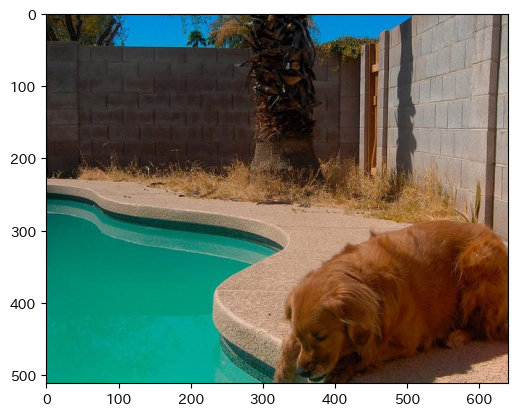

--------------------
['<s> ##Instruction: Write a short and informative description that highlights the primary subjects and actions occurring in the given image. ##Question:  ##Answer: A dog is sitting on the floor next to a plate of food.</s>']
##Instruction: Write a short and informative description that highlights the primary subjects and actions occurring in the given image. ##Question:  ##Answer: Shaggy dog gets dinner served on a plate.


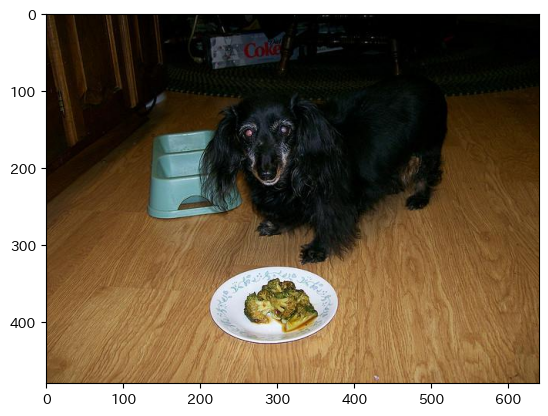

--------------------
['<s> ##Instruction: Write a brief, yet comprehensive, description of the image. ##Question:  ##Answer: A person walking on a dirt road with a dog.</s>']
##Instruction: Write a brief, yet comprehensive, description of the image. ##Question:  ##Answer: a person and a dog are standing near some cliffs


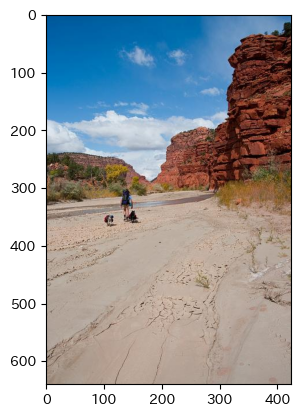

In [7]:
coco_datasets = datasets.load_dataset("MMInstruction/M3IT", "coco")
test_dataset = coco_datasets["test"]
supervised_test_dataset = SupervisedDataset(model_name, vision_model_name, test_dataset, 256)

for i in range(170, 300, 10):
    data, img, text, full_text = supervised_test_dataset[i]
    print('-'*20)
    print(generate_text(model, data))
    print(full_text)
    plt.figure()
    plt.imshow(np.array(img))
    plt.show()
    plt.clf()
    plt.close()

Found cached dataset m3_it (/home/y_inoue/.cache/huggingface/datasets/MMInstruction___m3_it/text-vqa/1.0.0/631dfd20153e0fbacb50b0239d4a71727503813fa0e821ba5ab399bed706034e)


  0%|          | 0/2 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--------------------
['<s> ##Instruction: Examine the provided image and corresponding OCR tokens carefully, and answer the associated questions thoroughly. ##Question: is this note in cursive? ##Answer: Yes, the note is in cursive.</s>']
##Instruction: Examine the provided image and corresponding OCR tokens carefully, and answer the associated questions thoroughly. ##Question: is this note in cursive? ##Answer: 


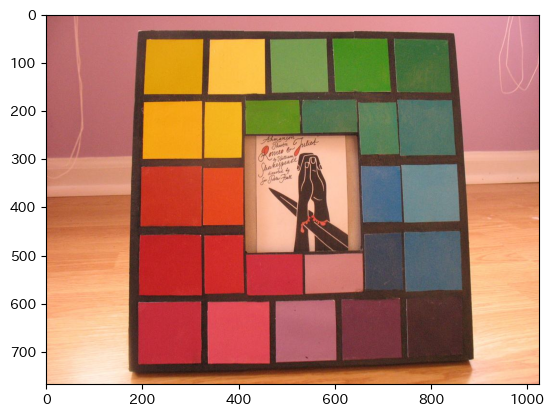

--------------------
['<s> ##Instruction: Analyze the supplied picture and OCR tokens closely, and provide comprehensive responses to the related questions. ##Question: what kind of lager is pictured? ##Answer: The lager pictured is a Heineken.</s>']
##Instruction: Analyze the supplied picture and OCR tokens closely, and provide comprehensive responses to the related questions. ##Question: what kind of lager is pictured? ##Answer: 


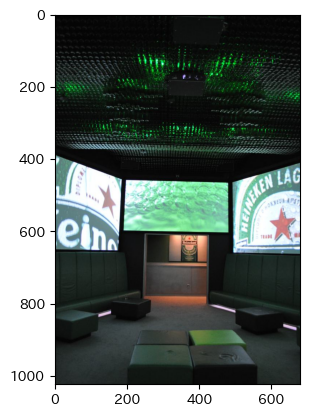

--------------------
["<s> ##Instruction: Carefully examine both the image and OCR tokens provided, and respond to the relevant questions. ##Question: is this running windows xp? ##Answer: I'm sorry, but I couldn't understand the answer. Could you please provide more context or clarify the question?</s>"]
##Instruction: Carefully examine both the image and OCR tokens provided, and respond to the relevant questions. ##Question: is this running windows xp? ##Answer: 


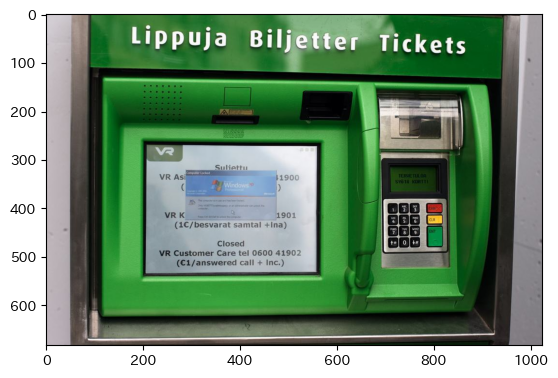

In [8]:
coco_datasets = datasets.load_dataset("MMInstruction/M3IT", "text-vqa")
test_dataset = coco_datasets["test"]
supervised_test_dataset = SupervisedDataset(model_name, vision_model_name, test_dataset, 256)

for i in range(170, 200, 10):
    data, img, text, full_text = supervised_test_dataset[i]
    print('-'*20)
    print(generate_text(model, data))
    print(full_text)
    plt.figure()
    plt.imshow(np.array(img))
    plt.show()
    plt.clf()
    plt.close()

Found cached dataset m3_it (/home/y_inoue/.cache/huggingface/datasets/MMInstruction___m3_it/shapes/1.0.0/631dfd20153e0fbacb50b0239d4a71727503813fa0e821ba5ab399bed706034e)


  0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--------------------
["<s> ##Instruction: Look at the image and answer the question about the configuration of colored shapes with either a 'yes' or 'no'. ##Question: is a red shape below below a green shape? ##Answer: The answer is no.</s>"]
##Instruction: Look at the image and answer the question about the configuration of colored shapes with either a 'yes' or 'no'. ##Question: is a red shape below below a green shape? ##Answer: The answer is no.


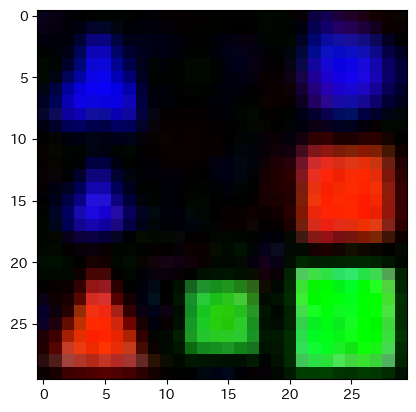

--------------------
["<s> ##Instruction: Review the image and answer the inquiry related to the shapes' color attributes and their arrangement within the composition with a 'yes' or 'no' response. ##Question: is a red shape below below a green shape? ##Answer: The answer is no.</s>"]
##Instruction: Review the image and answer the inquiry related to the shapes' color attributes and their arrangement within the composition with a 'yes' or 'no' response. ##Question: is a red shape below below a green shape? ##Answer: The answer is no.


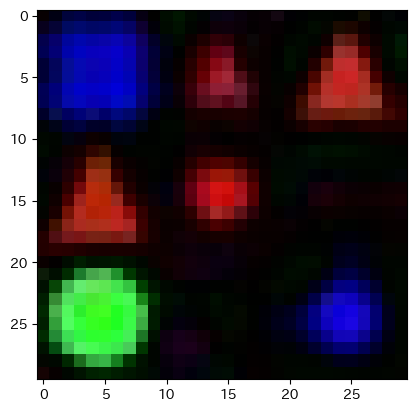

--------------------
["<s> ##Instruction: Assess the image provided, and determine if the statement regarding the spatial arrangement and colors of the shapes is true or false. Respond with a 'yes' or 'no'. ##Question: is a red shape below below a green shape? ##Answer: The answer is no.</s>"]
##Instruction: Assess the image provided, and determine if the statement regarding the spatial arrangement and colors of the shapes is true or false. Respond with a 'yes' or 'no'. ##Question: is a red shape below below a green shape? ##Answer: The answer is no.


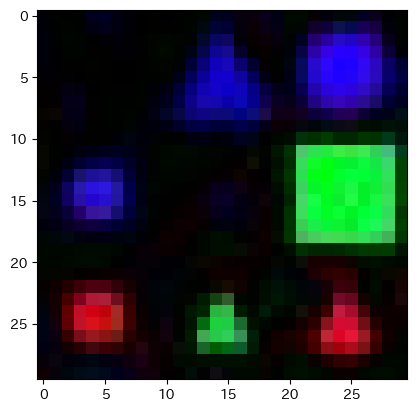

In [9]:
coco_datasets = datasets.load_dataset("MMInstruction/M3IT", "shapes")
test_dataset = coco_datasets["test"]
supervised_test_dataset = SupervisedDataset(model_name, vision_model_name, test_dataset, 256)

for i in range(170, 200, 10):
    data, img, text, full_text = supervised_test_dataset[i]
    print('-'*20)
    print(generate_text(model, data))
    print(full_text)
    plt.figure()
    plt.imshow(np.array(img))
    plt.show()
    plt.clf()
    plt.close()

Found cached dataset m3_it (/home/y_inoue/.cache/huggingface/datasets/MMInstruction___m3_it/viquae/1.0.0/631dfd20153e0fbacb50b0239d4a71727503813fa0e821ba5ab399bed706034e)


  0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--------------------
['<s> ##Instruction: Observe the image closely, recognize the named entities present, and use your knowledge to answer the question in relation to those entities. ##Question: Which famous artist spent four years painting the ceiling of this chapel? ##Answer: The famous artist who spent four years painting the ceiling of this chapel is Michelangelo.</s>']
##Instruction: Observe the image closely, recognize the named entities present, and use your knowledge to answer the question in relation to those entities. ##Question: Which famous artist spent four years painting the ceiling of this chapel? ##Answer: Michelangelo is the renowned artist who spent nearly four years painting the ceiling of the chapel depicted in the image.


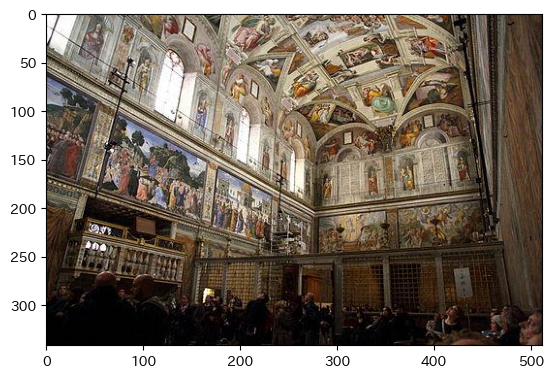

--------------------
['<s> ##Instruction: Assess the image for the presence of named entities, and accurately answer the question posed. ##Question: "In what city did this man and Joe Frazier have a ""thrilling"" fight?" ##Answer: The man and Joe Frazier had a "thrilling" fight in New York City.</s>']
##Instruction: Assess the image for the presence of named entities, and accurately answer the question posed. ##Question: "In what city did this man and Joe Frazier have a ""thrilling"" fight?" ##Answer: The exhilarating boxing match between this man and Joe Frazier took place in the city of Manila.


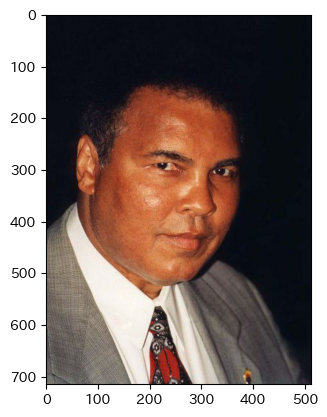

--------------------
['<s> ##Instruction: Analyze the image to locate any named entities and provide an appropriate response to the question. ##Question: He wrote dramas dealing with which legendary woman? ##Answer: The legendary woman in question is Medea, who is a character from Greek mythology.</s>']
##Instruction: Analyze the image to locate any named entities and provide an appropriate response to the question. ##Question: He wrote dramas dealing with which legendary woman? ##Answer: The dramas written by him revolved around the mythical figure of Electra.


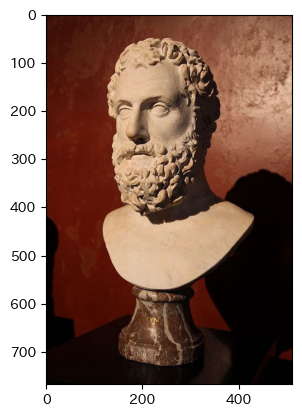

In [10]:
coco_datasets = datasets.load_dataset("MMInstruction/M3IT", "viquae")
test_dataset = coco_datasets["test"]
supervised_test_dataset = SupervisedDataset(model_name, vision_model_name, test_dataset, 256)

for i in range(170, 200, 10):
    data, img, text, full_text = supervised_test_dataset[i]
    print('-'*20)
    print(generate_text(model, data))
    print(full_text)
    plt.figure()
    plt.imshow(np.array(img))
    plt.show()
    plt.clf()
    plt.close()

Found cached dataset m3_it (/home/y_inoue/.cache/huggingface/datasets/MMInstruction___m3_it/vcr/1.0.0/631dfd20153e0fbacb50b0239d4a71727503813fa0e821ba5ab399bed706034e)


  0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Input length of input_ids is 309, but `max_length` is set to 256. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


--------------------
["<s>##Instruction: Instruction:\nAnswer the question related to the bounded objects in the given image and provide a justification for your answer.\n ##Question: Objects:\nThe 0-th object is person in the red color box.\nThe 1-th object is person in the blue color box.\nThe 2-th object is train in the green color box.\nThe 3-th object is tie in the pink color box.\nThe 4-th object is bottle in the light_blue color box.\nQuestion:\nAre the 1-th object and the 2-th object shopping together ?\nAnswer Choices:\nAnswer (A) Yes , they are shopping together .\nAnswer (B) No they are not .\nAnswer (C) No the 0-th object is not shopping .\nAnswer (D) Yes the 1-th object and the 2-th object are together .\nRationale Choices:\nRationale (A) the 1-th object and the 2-th object shop at the same store .\nRationale (B) Strangers don ' t usually stand so close to each other while shopping .\nRationale (C) They are shopping for baby supplies together .\nRationale (D) the 1-th obje

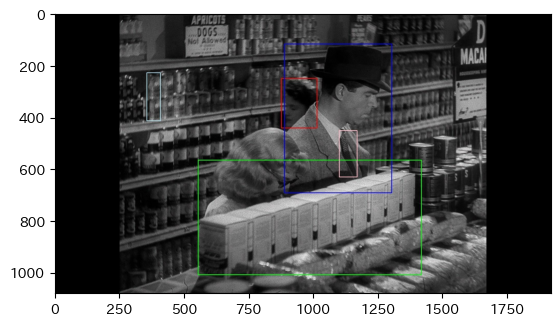

Input length of input_ids is 378, but `max_length` is set to 256. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


--------------------
["<s>##Instruction: Instruction:\nWith reference to the given image and its bounded objects, answer the question and provide a logical explanation for your response.\n ##Question: Objects:\nThe 0-th object is person in the red color box.\nThe 1-th object is person in the blue color box.\nThe 2-th object is person in the green color box.\nThe 3-th object is person in the pink color box.\nThe 4-th object is tie in the light_blue color box.\nThe 5-th object is chair in the light_green color box.\nThe 6-th object is couch in the purple color box.\nThe 7-th object is couch in the gray color box.\nThe 8-th object is book in the black color box.\nQuestion:\nIs the 0-th object feeling happiness ?\nAnswer Choices:\nAnswer (A) No . they are happy they get to see their idol .\nAnswer (B) No , the 2-th object is happy for the 0-th object .\nAnswer (C) No , the 0-th object is not feeling happy .\nAnswer (D) Yes , the 0-th object is very excited .\nRationale Choices:\nRationale 

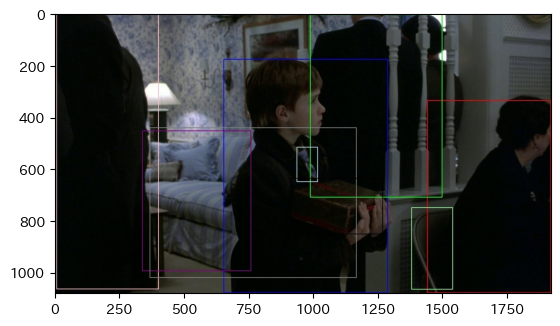

Input length of input_ids is 439, but `max_length` is set to 256. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


--------------------
["<s>##Instruction: Instruction:\nDemonstrate your understanding of the bounded objects in the given image by answering the question and justifying your response.\n ##Question: Objects:\nThe 0-th object is person in the red color box.\nThe 1-th object is person in the blue color box.\nThe 2-th object is person in the green color box.\nThe 3-th object is person in the pink color box.\nThe 4-th object is person in the light_blue color box.\nThe 5-th object is handbag in the light_green color box.\nThe 6-th object is tie in the purple color box.\nThe 7-th object is tie in the gray color box.\nQuestion:\nWhat are the 3-th object and the 2-th object discussing ?\nAnswer Choices:\nAnswer (A) Where the money might be .\nAnswer (B) They are discussing a game of basketball that the 3-th object just played .\nAnswer (C) They are taking about travel .\nAnswer (D) the 3-th object and the 2-th object are saying their goodbyes .\nRationale Choices:\nRationale (A) the 2-th object

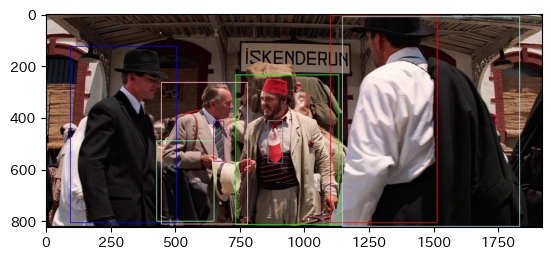

In [11]:
coco_datasets = datasets.load_dataset("MMInstruction/M3IT", "vcr")
test_dataset = coco_datasets["test"]
supervised_test_dataset = SupervisedDataset(model_name, vision_model_name, test_dataset, 256)

for i in range(170, 200, 10):
    data, img, text, full_text = supervised_test_dataset[i]
    print('-'*20)
    print(generate_text(model, data))
    print(full_text)
    plt.figure()
    plt.imshow(np.array(img))
    plt.show()
    plt.clf()
    plt.close()

Found cached dataset m3_it (/home/y_inoue/.cache/huggingface/datasets/MMInstruction___m3_it/visual-mrc/1.0.0/631dfd20153e0fbacb50b0239d4a71727503813fa0e821ba5ab399bed706034e)


  0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--------------------
['<s> ##Instruction: Please answer the question based on the image and its relevant bounded objects.\n ##Question: FDA denied AMT-130 investigational status?\n ##Answer: Yes, FDA denied AMT-130 investigational status.</s>']
##Instruction: Please answer the question based on the image and its relevant bounded objects.
 ##Question: FDA denied AMT-130 investigational status?
 ##Answer: No, it was approved.


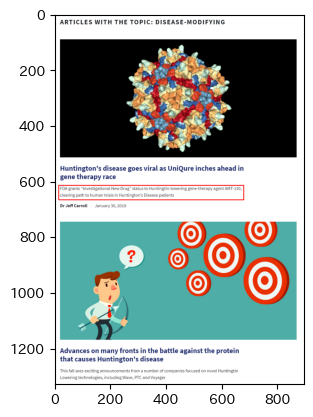

--------------------
["<s> ##Instruction: The task is to answer the question using the provided image and its corresponding confined entities.\n ##Question: What city is the Huntington's disease therapeutics conference?\n ##Answer: The Huntington's disease therapeutics conference is in San Diego.</s>"]
##Instruction: The task is to answer the question using the provided image and its corresponding confined entities.
 ##Question: What city is the Huntington's disease therapeutics conference?
 ##Answer: The Huntington's disease therapeutics conference will be held in Palm Springs.


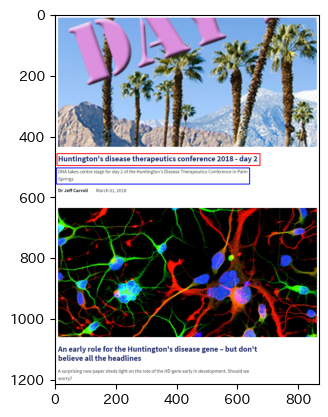

--------------------
['<s> ##Instruction: Utilizing the given picture and its associated restricted entities, provide a response to the inquiry.\n ##Question: Are there different kinds of small rna molecules?\n ##Answer: Yes, there are different kinds of small rna molecules.</s>']
##Instruction: Utilizing the given picture and its associated restricted entities, provide a response to the inquiry.
 ##Question: Are there different kinds of small rna molecules?
 ##Answer: Yes


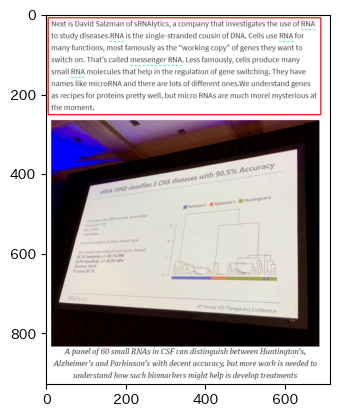

In [12]:
coco_datasets = datasets.load_dataset("MMInstruction/M3IT", "visual-mrc")
test_dataset = coco_datasets["test"]
supervised_test_dataset = SupervisedDataset(model_name, vision_model_name, test_dataset, 256)

for i in range(170, 200, 10):
    data, img, text, full_text = supervised_test_dataset[i]
    print('-'*20)
    print(generate_text(model, data))
    print(full_text)
    plt.figure()
    plt.imshow(np.array(img))
    plt.show()
    plt.clf()
    plt.close()

Found cached dataset m3_it (/home/y_inoue/.cache/huggingface/datasets/MMInstruction___m3_it/multi30k/1.0.0/631dfd20153e0fbacb50b0239d4a71727503813fa0e821ba5ab399bed706034e)


  0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--------------------
['<s> ##Instruction: Using the image and its caption, translate the sentence from the source language to the target language.\n ##Question: Source langauge: English (en)\nSource sentence: Women, wearing traditional clothing, are reenacting native life.\nTarget langauge: French (fr)\n ##Answer: Des femmes, vêtues de vêtements traditionnels, réenactent la vie native.</s>']
##Instruction: Using the image and its caption, translate the sentence from the source language to the target language.
 ##Question: Source langauge: English (en)
Source sentence: Women, wearing traditional clothing, are reenacting native life.
Target langauge: French (fr)
 ##Answer: Des femmes, portant des vêtements traditionnels, reproduisent leur mode de vie natal.


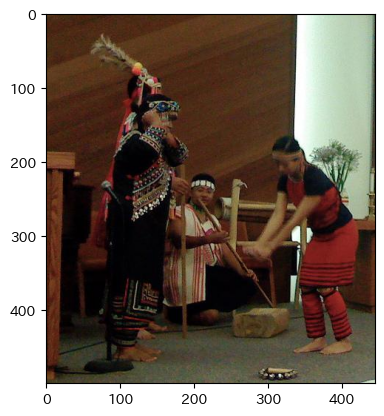

--------------------
['<s> ##Instruction: Using the provided image and its description, translate the sentence from the source language to the target language.\n ##Question: Source langauge: English (en)\nSource sentence: Six people ride mountain bikes through a jungle environment.\nTarget langauge: Czech (cs)\n ##Answer: Sedm lidí jede na kolech po jungli.</s>']
##Instruction: Using the provided image and its description, translate the sentence from the source language to the target language.
 ##Question: Source langauge: English (en)
Source sentence: Six people ride mountain bikes through a jungle environment.
Target langauge: Czech (cs)
 ##Answer: Šest lidí jedoucích na horských kolech uprostřed džungle.


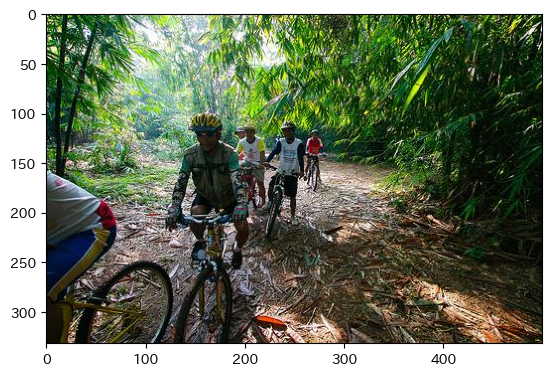

--------------------
['<s> ##Instruction: Using the accompanying image and description, translate the sentence from the source language to the target language.\n ##Question: Source langauge: German (de)\nSource sentence: 2 blonde Mädchen sitzen auf einem Absatz auf einem belebten Platz.\nTarget langauge: English (en)\n ##Answer: Two blond girls sit on a bench on a busy street.</s>']
##Instruction: Using the accompanying image and description, translate the sentence from the source language to the target language.
 ##Question: Source langauge: German (de)
Source sentence: 2 blonde Mädchen sitzen auf einem Absatz auf einem belebten Platz.
Target langauge: English (en)
 ##Answer: 2 blond girls are sitting on a ledge in a crowded plaza.


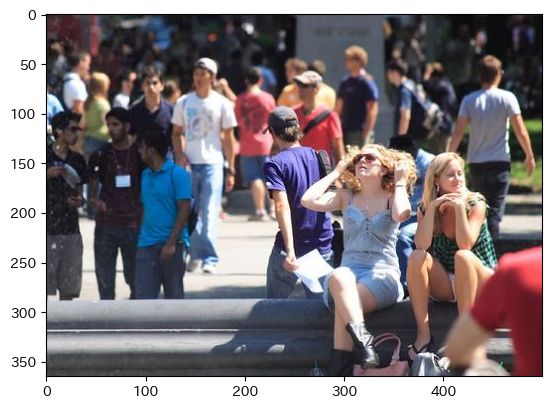

In [13]:
coco_datasets = datasets.load_dataset("MMInstruction/M3IT", "multi30k")
test_dataset = coco_datasets["test"]
supervised_test_dataset = SupervisedDataset(model_name, vision_model_name, test_dataset, 256)

for i in range(170, 200, 10):
    data, img, text, full_text = supervised_test_dataset[i]
    print('-'*20)
    print(generate_text(model, data))
    print(full_text)
    plt.figure()
    plt.imshow(np.array(img))
    plt.show()
    plt.clf()
    plt.close()

--------------------
<s> ##Instruction: Please answer the following question concletely. ##Question: What is unusual about this image? Explain precisely and concletely what he is doing? ##Answer: 
The image shows a man standing on top of a car with a yellow umbrella. This is an unusual sight as it is not common to see a person standing on top of a car.</s>


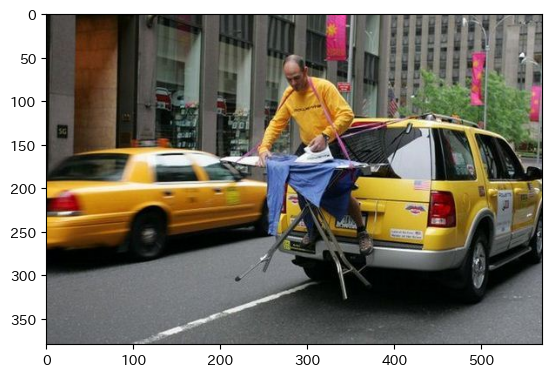

In [14]:
import requests

url = "https://www.barnorama.com/wp-content/uploads/2016/12/03-Confusing-Pictures.jpg"
image = Image.open(requests.get(url, stream=True).raw)

text = f"##Instruction: Please answer the following question concletely. ##Question: What is unusual about this image? Explain precisely and concletely what he is doing? ##Answer: "

inputs = supervised_test_dataset.process_data(text, image)

print('-'*20)
print(generate_text(model, inputs)[0])
plt.figure()
plt.imshow(np.array(image))
plt.show()
plt.clf()
plt.close()